In [22]:
import os.path as op
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from mubench.utils.macro import DATASET_NAMES, MODEL_NAMES, UncertaintyMethods

from sklearn.metrics import (
    roc_auc_score,
    mean_squared_error,
    mean_absolute_error,
    precision_recall_curve,
    auc,
    roc_curve
)
from torchmetrics.functional.classification import binary_calibration_error


## Classification metrics

In [37]:
result_folder = '../output/'

dataset_name = 'tox21'
assert dataset_name in DATASET_NAMES
model_name = 'DNN'
assert model_name in MODEL_NAMES

uncertainty_method = UncertaintyMethods.none
feature_type = 'rdkit'
seed = 0
test_run_idx = 0

if model_name == "DNN" and feature_type != 'none':
    model_name = f"{model_name}-{feature_type}"


In [38]:
result_path = op.join(result_folder, dataset_name, model_name, uncertainty_method, f"seed-{seed}", "preds", f"{test_run_idx}.pt")
results = torch.load(result_path)

lbs = results['lbs']
preds = results['preds']['preds']
masks = results['masks']

### Macro-averaged roc-auc

In [39]:
roc_auc_list = list()
all_preds_ = list()
for i in range(lbs.shape[-1]):
    lbs_ = lbs[:, i][masks[:, i].astype(bool)]
    preds_ = preds[:, i][masks[:, i].astype(bool)]
    all_preds_.append(preds_)
    roc_auc = roc_auc_score(lbs_, preds_)
    roc_auc_list.append(roc_auc)
roc_auc_avg = np.mean(roc_auc_list)

print(roc_auc_list, roc_auc_avg)


[0.7750184638109305, 0.7856924954240391, 0.7744149700092928, 0.7359840373759005, 0.6808434694269789, 0.766912071120989, 0.7093917112299465, 0.7004369328275795, 0.6739407524613221, 0.7056663606776266, 0.832674522673031, 0.7469571944301185] 0.7406610817889795


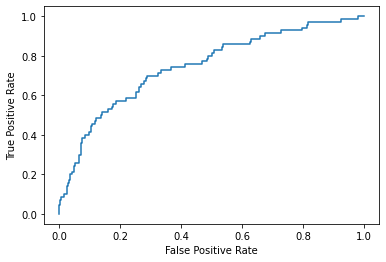

In [30]:
fpr, tpr, _ = roc_curve(lbs_,  preds_)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [31]:
uncertainty_method = UncertaintyMethods.temperature
result_path = op.join(result_folder, dataset_name, model_name, uncertainty_method, f"seed-{seed}", "preds", f"{test_run_idx}.pt")
results = torch.load(result_path)
preds1 = results['preds']['preds']

In [40]:
roc_auc_list = list()
for i in range(lbs.shape[-1]):
    lbs_ = lbs[:, i][masks[:, i].astype(bool)]
    preds_ = preds1[:, i][masks[:, i].astype(bool)]
    print(preds_ == all_preds_[i])
    roc_auc = roc_auc_score(lbs_, preds_)
    roc_auc_list.append(roc_auc)
roc_auc_avg = np.mean(roc_auc_list)
print(roc_auc_list, roc_auc_avg)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

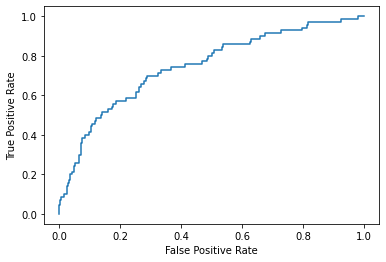

In [33]:
fpr1, tpr1, _ = roc_curve(lbs_,  preds_)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Macro-averaged prc-auc

In [91]:
prc_auc_list = list()
for i in range(lbs.shape[-1]):
    lbs_ = lbs[:, i][masks[:, i].astype(bool)]
    preds_ = preds[:, i][masks[:, i].astype(bool)]
    p, r, _ = precision_recall_curve(lbs_, preds_)
    prc_auc = auc(r, p)
    prc_auc_list.append(prc_auc)
prc_auc_avg = np.mean(prc_auc_list)


In [92]:
print(prc_auc_list, prc_auc_avg)

[0.5020467980713031, 0.5308472315785736, 0.42030936176201217, 0.22119198642187377, 0.3926350235091736, 0.3144283962189145, 0.09593395067519724, 0.5049174066962185, 0.25277948282200463, 0.19554492350750857, 0.571195952499776, 0.33014443949625305] 0.3609979127715674


### Expected Calibration Error

In [93]:
ece_list = list()
for i in range(lbs.shape[-1]):
    lbs_ = lbs[:, i][masks[:, i].astype(bool)]
    preds_ = preds[:, i][masks[:, i].astype(bool)]
    ece = binary_calibration_error(torch.from_numpy(preds_), torch.from_numpy(lbs_)).item()
    ece_list.append(ece)
ece_avg = np.mean(ece_list)

In [94]:
print(ece_list, ece_avg)

[0.03527170792222023, 0.02535352110862732, 0.0663517490029335, 0.03395678102970123, 0.05184989422559738, 0.051950603723526, 0.011623824015259743, 0.08465956151485443, 0.04783053696155548, 0.03616580367088318, 0.06094920262694359, 0.03106909804046154] 0.04475269032021364


### Maximum Calibration Error

In [95]:
mce_list = list()
for i in range(lbs.shape[-1]):
    lbs_ = lbs[:, i][masks[:, i].astype(bool)]
    preds_ = preds[:, i][masks[:, i].astype(bool)]
    mce = binary_calibration_error(torch.from_numpy(preds_), torch.from_numpy(lbs_), norm='max').item()
    mce_list.append(mce)
mce_avg = np.mean(mce_list)


In [96]:
print(mce_list, mce_avg)


[0.7613016963005066, 0.8440595865249634, 0.393152117729187, 0.2902507781982422, 0.4681076109409332, 0.8364065289497375, 0.4697633981704712, 0.2637096643447876, 0.36381763219833374, 0.5380767583847046, 0.29988473653793335, 0.09579083323478699] 0.46869344512621564


## Regression Metrics

In [120]:
result_folder = '../output/'

dataset_name = 'esol'
assert dataset_name in DATASET_NAMES
model_name = 'DNN'
assert model_name in MODEL_NAMES

uncertainty_method = UncertaintyMethods.none
feature_type = 'rdkit'
seed = 0
test_run_idx = 0

if model_name == "DNN" and feature_type != 'none':
    model_name = f"{model_name}-{feature_type}"

result_path = op.join(result_folder, dataset_name, model_name, uncertainty_method, f"seed-{seed}", "preds",
                      f"{test_run_idx}.pt")
results = torch.load(result_path)


In [135]:
lbs = results['lbs']
preds = results['preds']['preds']
variances = results['preds']['vars']
masks = results['masks']

if len(preds.shape) == 1:
    preds = preds[:, np.newaxis]

if len(variances.shape) == 1:
    variances = variances[:, np.newaxis]



### RMSE

In [140]:
rmse_list = list()
for i in range(lbs.shape[-1]):
    lbs_ = lbs[:, i][masks[:, i].astype(bool)]
    preds_ = preds[:, i][masks[:, i].astype(bool)]
    rmse = mean_squared_error(lbs_, preds_, squared=False)
    rmse_list.append(rmse)
rmse_avg = np.mean(rmse_list)
print(rmse_list, rmse_avg)

[0.9062639287855146] 0.9062639287855146


### MAE

In [141]:
mae_list = list()
for i in range(lbs.shape[-1]):
    lbs_ = lbs[:, i][masks[:, i].astype(bool)]
    preds_ = preds[:, i][masks[:, i].astype(bool)]
    mae = mean_absolute_error(lbs_, preds_)
    mae_list.append(mae)
mae_avg = np.mean(mae_list)
print(mae_list, mae_avg)

[0.7081242712225955] 0.7081242712225955


### Gaussian negative log likelihood

In [144]:
nll_list = list()
for i in range(lbs.shape[-1]):
    lbs_ = lbs[:, i][masks[:, i].astype(bool)]
    preds_ = preds[:, i][masks[:, i].astype(bool)]
    vars_ = variances[:, i][masks[:, i].astype(bool)]
    nll = F.gaussian_nll_loss(torch.from_numpy(preds_), torch.from_numpy(lbs_), torch.from_numpy(vars_)).item()
    nll_list.append(nll)
nll_avg = np.mean(nll_list)
print(nll_list, nll_avg)

[0.37371532391765244] 0.37371532391765244
